In [10]:
import pymc as pm
import arviz as az
import scipy.stats as ss
import numpy as np

### Task 1

In [12]:
data = ss.norm.rvs(size=1000, random_state=1337)
data = data[(data > -1) & (data < 2)]

In [17]:
with pm.Model() as model:
    mu = pm.Flat("mu")
    sigma = pm.HalfFlat("sigma")
    pm.Potential("log_prior", -pm.math.log(sigma))

    L = pm.Exponential("L", lam=1)
    U = pm.Exponential("U", lam=1)
    lower = pm.Deterministic("lower", data.min() - L)
    upper = pm.Deterministic("upper", data.max() + U)

    y = pm.Truncated("y", pm.Normal.dist(mu=mu, sigma=sigma), lower=lower, upper=upper, observed=data)

    trace = pm.sample(10000, chains=1, tune=1000)

Initializing NUTS using jitter+adapt_diag...
C:\Users\pzns1\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1023: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Sequential sampling (1 chains in 1 job)
NUTS: [mu, sigma, L, U]


Output()

C:\Users\pzns1\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\tensor\elemwise.py:731: 
RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

C:\Users\pzns1\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\tensor\elemwise.py:731: 
RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

C:\Users\pzns1\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\tensor\elemwise.py:731: 
RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 325 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [22]:
sigma_hdi = az.hdi(trace, var_names=["sigma"], hdi_prob=0.95)["sigma"]
print(f"95% HDI for sigma: {sigma_hdi[0]:.8f} {sigma_hdi[1]:.8f}")

95% HDI for sigma: 0.88637336 1.16400207


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'lower'}>,
        <Axes: title={'center': 'lower'}>],
       [<Axes: title={'center': 'upper'}>,
        <Axes: title={'center': 'upper'}>]], dtype=object)

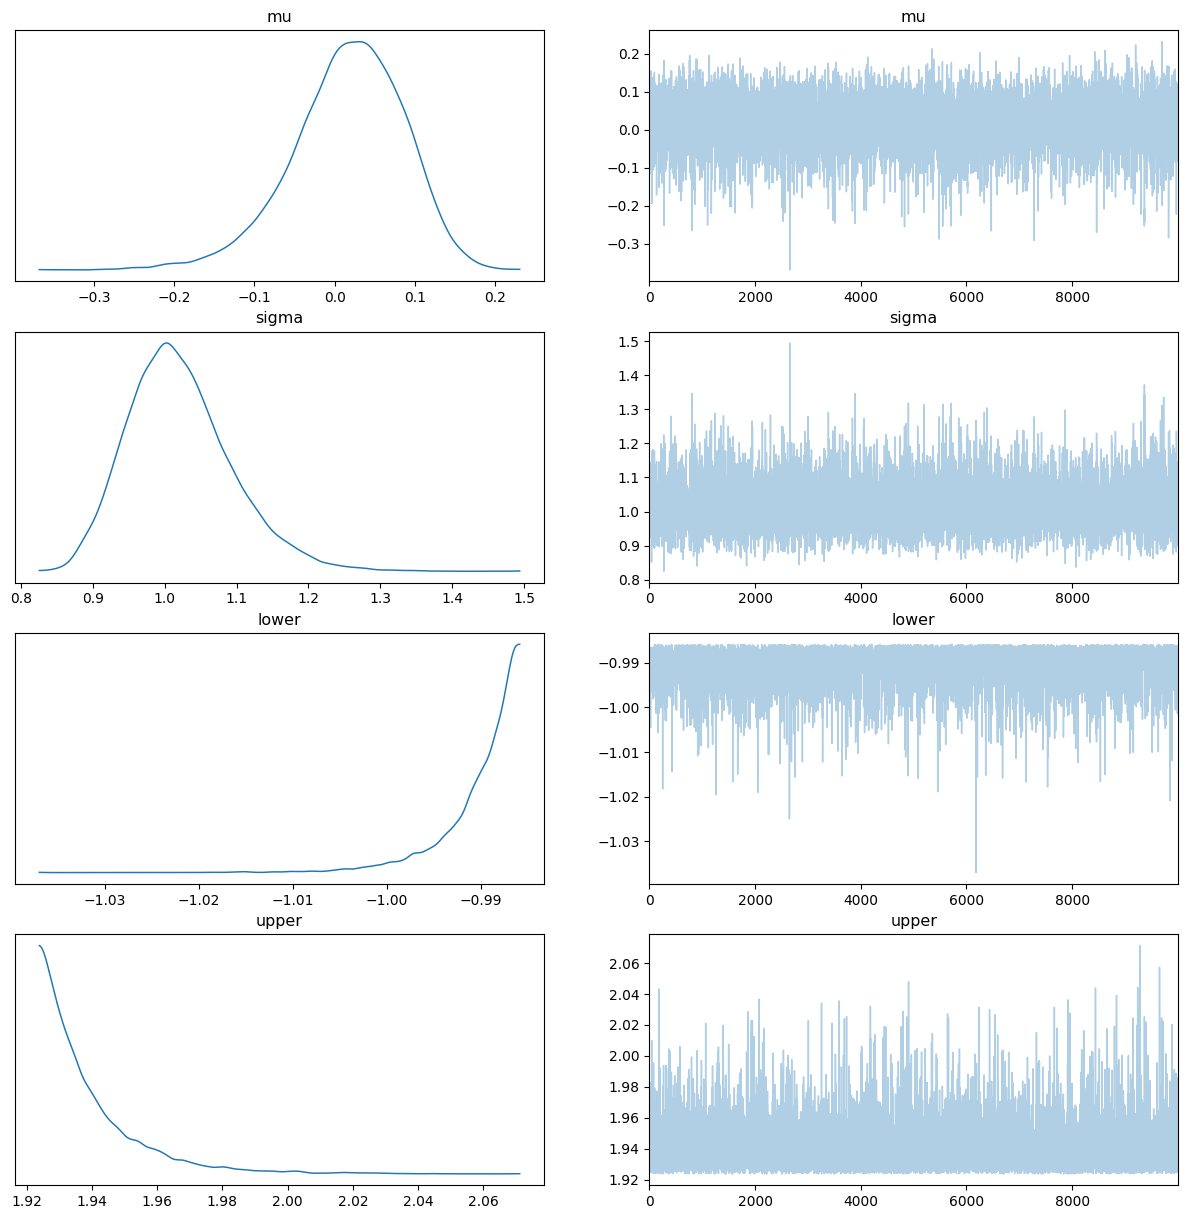

In [23]:
az.plot_trace(trace, var_names=["mu", "sigma", "lower", "upper"], figsize=(15,15))

1. Распределение lower имеет меньший разброс, чем upper, потому что исходные данные имеют гораздо более высокую плотность значений около нижней границы, чем около верхней => нижняя граница усечения определяется более точно.
2. Распределение параметра mu скошено влево, потому что усечение справа сильнее влияет на оценку среднего, чем усечение слева. Распределения справа обрезано на большем расстоянии от центра, что приводит к скосу оценки среднего влево.

### Task 2